In [1]:
# %run path/to/utils.py.ipynb (in this case, I had the utils.py.ipynb notebook in the same folder as the other notebooks)
# Running this will also let you know the version of tenserflow "TF" 
# In my case, I built the TF 2.10.0 version from source for the Windows environment --> latest tenserflow version that supports training models on a gpu in Windows
# Please be aware that you may need to pick the numpy and pandas versions carefully to avoid issues with running this notebook (numpy version = pandas version = ) 
    ## For more details please visit the tensorflow website (build from source - windows): https://www.tensorflow.org/install/source_windows
%run utils.py.ipynb

TF version: 2.10.0 

GPUs Detected:  1
Current device: [(PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), {'device_name': 'NVIDIA GeForce RTX 4060 Laptop GPU', 'compute_capability': (8, 9)})]
TF built with GPU support: True
TF built with cuda support: True 

GPU is available!

Current GPU usage by TF: {'current': 2048, 'peak': 2560}


# Many-to-Many (Sequence-to-Sequence) Bi-LSTM Example

## Contents: 
- Dataset Creation
- Training Model
- Saving Model
- Displaying Results
- Saving Results
- Loading Model
- Evaluating Model
- Additional Examples: (Many-to-One) + LSTM, GRU, Bi-GRU, ANN, Linear Regression

In [2]:
# Enter path of the excel file
Production_data_path = 'Example_Data.xlsx'
excelfile = pd.ExcelFile(Production_data_path)
# Find all sheet names of the excel file in given path
all_sheets = pd.ExcelFile(Production_data_path).sheet_names

# Allow user to select multiple sheet names from a single Excel file in a GUI 
# RETURN VARILABLE NAME: "user_selected_sheets" --> set as a global variable inside "select_sheets" function
user_selected_sheets = select_sheets(sheet_names = all_sheets)
# from my_methods import user_selected_sheets # importing the global variable after setting it up using the GUI (user_selected_sheets is a global variable that is created after executing the GUI)

# Define an empty list to store individual DataFrames
list_of_dfs = []

for sheet in user_selected_sheets:
    
    # Parse data from each worksheet as a Pandas DataFrame
    df = excelfile.parse(sheet)

    # And append it to the list
    list_of_dfs.append(df)
    
# Combine all DataFrames into one
Production_data = pd.concat(list_of_dfs, keys=user_selected_sheets, names=['Sheet_names',None]).reset_index(level=0).reset_index(drop=True)

# Print - High level info on production data
print('\nCountries:')
print(['United States']) # can be extracted from Production_data later
print('\nStates:')
print(['North Dakota']) # can be extracted from Production_data later
print('\nCounties:')
print(list(Production_data['County'].unique()))
print('\nReservoirs:')
print(list(Production_data['targetFormation'].unique()))
print('\nNumber of selected wells:')
print(len(Production_data['API/UWI List'].unique()))

# Print - Low level info on production data
print('\nFirst Production Years Interval:')
print (Production_data['firstProdDate'].min().year,'-',Production_data['firstProdDate'].max().year)
print('\nTrue Vertical Depth (TVD) variation')
print (Production_data['TVD'].min(),'-',Production_data['TVD'].max())

Selected sheets:
['Bakken', 'Three_Forks']

Countries:
['United States']

States:
['North Dakota']

Counties:
['MOUNTRAIL']

Reservoirs:
['BAKKEN', 'THREE FORKS']

Number of selected wells:
50

First Production Years Interval:
2011 - 2015

True Vertical Depth (TVD) variation
9311.29 - 10729.92


In [3]:
# Process data based on train, val, test percentages and remaining window size for val and test sets
train_percent = 0.6
val_percent = 0.2
test_percent = 0.2
label_columns = ['Monthly Oil','Monthly Gas','Monthly Water']
control_parameters = ['Days']

Processed_Production_data = process_data(Production_data = Production_data, train_percent = train_percent, val_percent = val_percent, test_percent = test_percent, label_columns = label_columns, control_parameters = control_parameters)

Number of wells in original data: 50
Number of wells removed: 5
Remaining number of wells: 45


In [4]:
# Visualize Processed Production Data
display(Processed_Production_data)

# Add First production date's month and year as part of the static variables to include in the model
Processed_Production_data['First_Prod_Month'] = Processed_Production_data['firstProdDate'].dt.month
Processed_Production_data['First_Prod_Year'] = Processed_Production_data['firstProdDate'].dt.year

,Sheet_names,Entity ID,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Days,Daily Avg Oil,Daily Avg Gas,...,horizontalLength,firstProdDate,stage,stageLength,stageper1kPI,maxInjRate,maxInjPres,totalProp,totalFluid,oilGravity
0,Bakken,1,1,2015-09-01,24394.0,19273.0,20965.0,21.0,813.13,642.43,...,9959.59,2015-08-01,50,212.54000,4.704997,30.6,8424,3503194,51053,44.2
1,Bakken,1,1,2015-10-01,10157.0,10885.0,5653.0,30.0,483.67,518.33,...,9959.59,2015-08-01,50,212.54000,4.704997,30.6,8424,3503194,51053,44.2
2,Bakken,1,1,2015-11-01,10803.0,11265.0,6482.0,31.0,360.10,375.50,...,9959.59,2015-08-01,50,212.54000,4.704997,30.6,8424,3503194,51053,44.2
3,Bakken,1,1,2015-12-01,10393.0,8879.0,5628.0,16.0,335.26,286.42,...,9959.59,2015-08-01,50,212.54000,4.704997,30.6,8424,3503194,51053,44.2
4,Bakken,1,1,2016-01-01,5601.0,5201.0,2516.0,16.0,350.06,325.06,...,9959.59,2015-08-01,50,212.54000,4.704997,30.6,8424,3503194,51053,44.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,Three_Forks,49,49,2022-04-01,630.0,1073.0,1137.0,31.0,21.00,35.77,...,10269.67,2011-10-01,27,365.62963,2.735008,47.4,8728,1636968,23502,40.0
4496,Three_Forks,49,49,2022-05-01,620.0,1231.0,1308.0,30.0,20.00,39.71,...,10269.67,2011-10-01,27,365.62963,2.735008,47.4,8728,1636968,23502,40.0
4497,Three_Forks,49,49,2022-06-01,644.0,1019.0,1231.0,31.0,21.47,33.97,...,10269.67,2011-10-01,27,365.62963,2.735008,47.4,8728,1636968,23502,40.0
4498,Three_Forks,49,49,2022-07-01,611.0,1058.0,1370.0,31.0,19.71,34.13,...,10269.67,2011-10-01,27,365.62963,2.735008,47.4,8728,1636968,23502,40.0


Training Data Max Production Period:
78
Validation Data Max Production Period:
26
Test Data Max Production Period:
27
Training Data Min Production Period:
45
Validation Data Min Production Period:
15
Test Data Min Production Period:
16
Time Series Length of Each Well (Train,Val,Test):


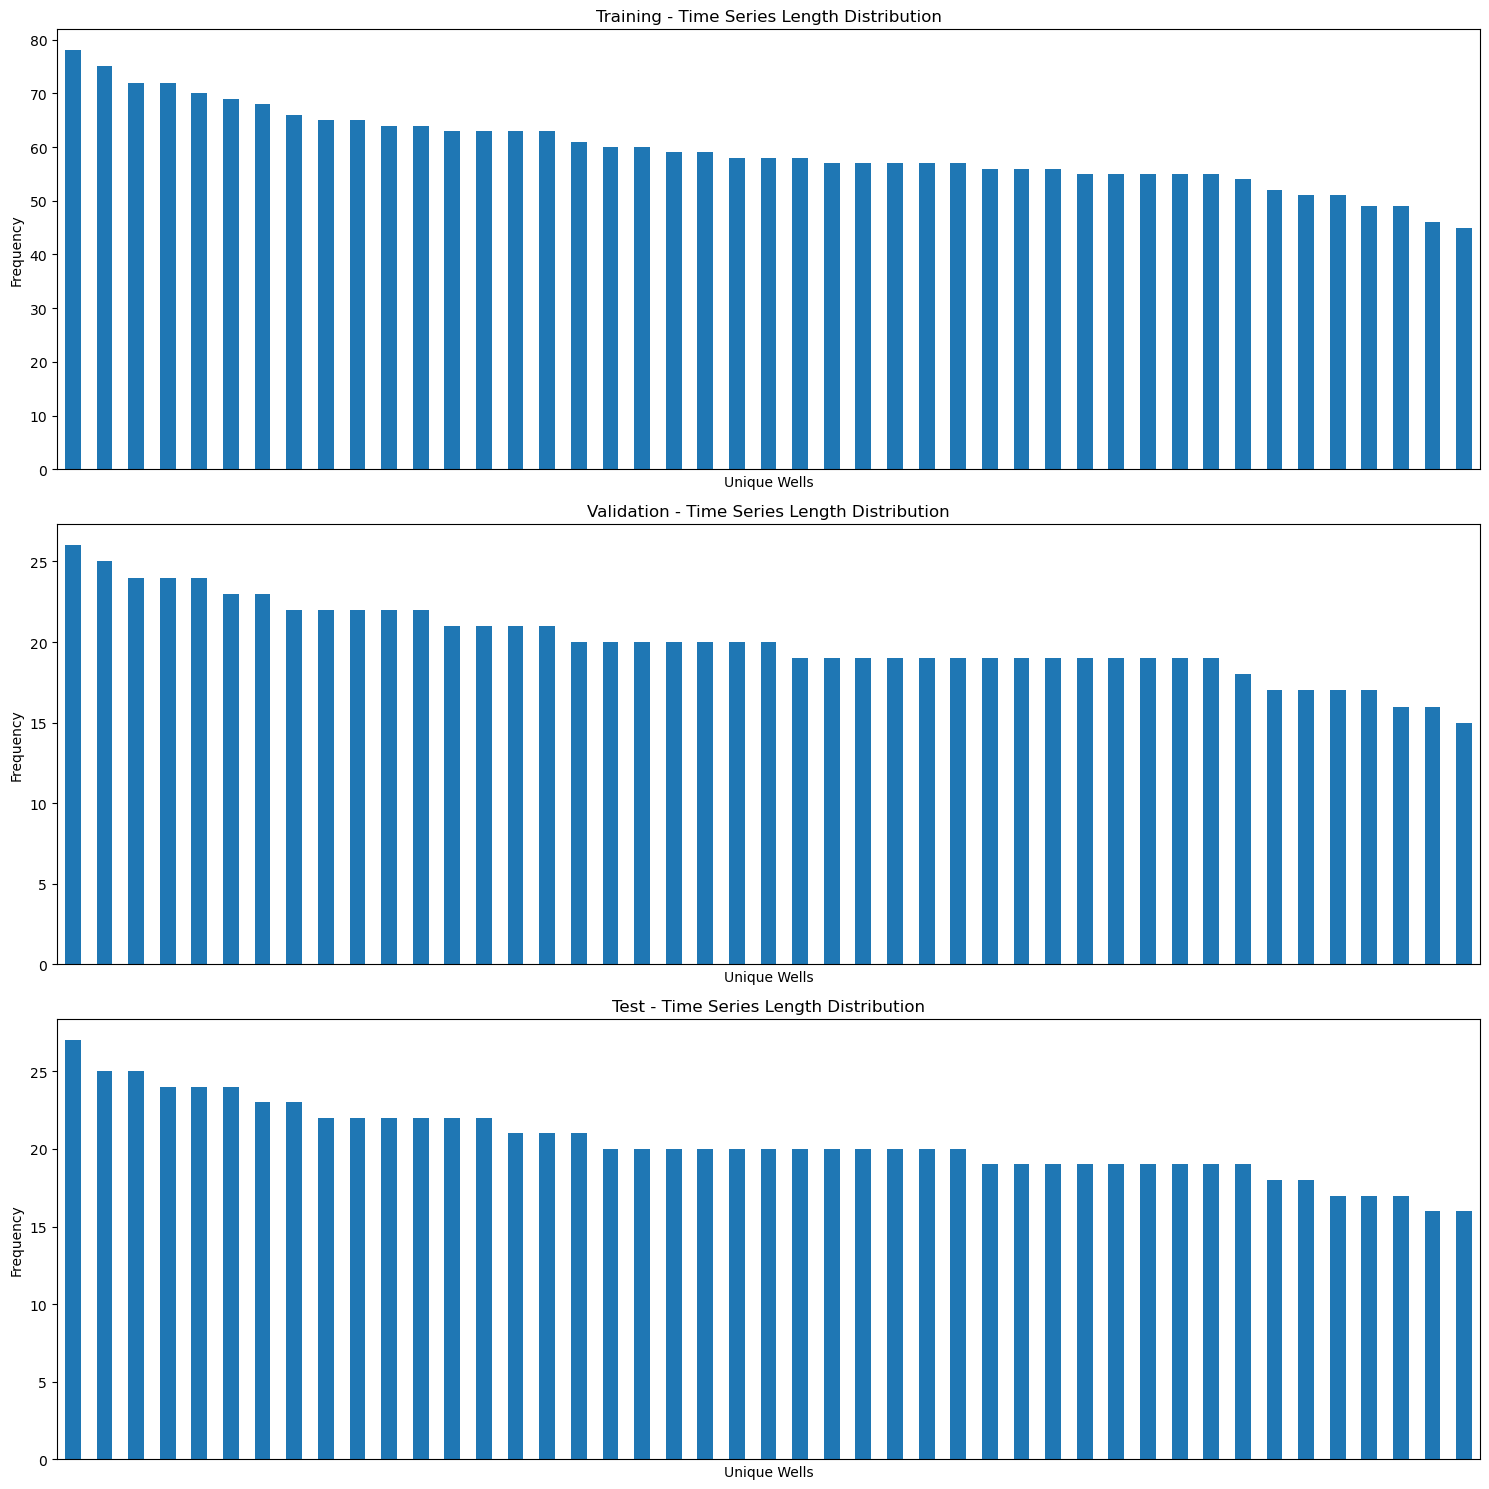


Training Data:


,Sheet_names,Entity ID,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Days,Daily Avg Oil,Daily Avg Gas,...,stageLength,stageper1kPI,maxInjRate,maxInjPres,totalProp,totalFluid,oilGravity,First_Prod_Month,First_Prod_Year,frequency
0,Bakken,1,1,2015-09-01,24394.0,19273.0,20965.0,21.0,813.13,642.43,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,49
1,Bakken,1,1,2015-10-01,10157.0,10885.0,5653.0,30.0,483.67,518.33,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,49
2,Bakken,1,1,2015-11-01,10803.0,11265.0,6482.0,31.0,360.10,375.50,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,49
3,Bakken,1,1,2015-12-01,10393.0,8879.0,5628.0,16.0,335.26,286.42,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,49
4,Bakken,1,1,2016-01-01,5601.0,5201.0,2516.0,16.0,350.06,325.06,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,Three_Forks,49,49,2017-12-01,806.0,1318.0,601.0,31.0,26.00,42.52,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,75
4446,Three_Forks,49,49,2018-01-01,802.0,1232.0,551.0,28.0,25.87,39.74,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,75
4447,Three_Forks,49,49,2018-02-01,783.0,1161.0,555.0,21.0,27.96,41.46,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,75
4448,Three_Forks,49,49,2018-03-01,600.0,852.0,397.0,19.0,28.57,40.57,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,75


Validation Data:


,Sheet_names,Entity ID,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Days,Daily Avg Oil,Daily Avg Gas,...,stageLength,stageper1kPI,maxInjRate,maxInjPres,totalProp,totalFluid,oilGravity,First_Prod_Month,First_Prod_Year,frequency
49,Bakken,1,1,2019-11-01,1874.0,2774.0,2513.0,31.0,62.47,92.47,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
50,Bakken,1,1,2019-12-01,1850.0,3280.0,1104.0,31.0,59.68,105.81,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
51,Bakken,1,1,2020-01-01,1120.0,1845.0,580.0,25.0,36.13,59.52,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
52,Bakken,1,1,2020-02-01,1125.0,1930.0,762.0,13.0,45.00,77.20,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
53,Bakken,1,1,2020-03-01,731.0,1407.0,206.0,30.0,56.23,108.23,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,Three_Forks,49,49,2020-03-01,756.0,982.0,607.0,30.0,24.39,31.68,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4471,Three_Forks,49,49,2020-04-01,750.0,1030.0,586.0,31.0,25.00,34.33,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4472,Three_Forks,49,49,2020-05-01,746.0,508.0,502.0,30.0,24.06,16.39,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4473,Three_Forks,49,49,2020-06-01,674.0,885.0,455.0,31.0,22.47,29.50,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25


Test Data:


,Sheet_names,Entity ID,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Days,Daily Avg Oil,Daily Avg Gas,...,stageLength,stageper1kPI,maxInjRate,maxInjPres,totalProp,totalFluid,oilGravity,First_Prod_Month,First_Prod_Year,frequency
66,Bakken,1,1,2021-04-01,959.0,4008.0,764.0,31.0,31.97,133.60,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
67,Bakken,1,1,2021-05-01,880.0,3561.0,915.0,30.0,28.39,114.87,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
68,Bakken,1,1,2021-06-01,845.0,4136.0,1009.0,22.0,28.17,137.87,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
69,Bakken,1,1,2021-07-01,761.0,3529.0,787.0,24.0,34.59,160.41,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
70,Bakken,1,1,2021-08-01,894.0,2793.0,1140.0,30.0,37.25,116.38,...,212.54000,4.704997,30.6,8424,3503194,51053,44.2,8,2015,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,Three_Forks,49,49,2022-04-01,630.0,1073.0,1137.0,31.0,21.00,35.77,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4496,Three_Forks,49,49,2022-05-01,620.0,1231.0,1308.0,30.0,20.00,39.71,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4497,Three_Forks,49,49,2022-06-01,644.0,1019.0,1231.0,31.0,21.47,33.97,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25
4498,Three_Forks,49,49,2022-07-01,611.0,1058.0,1370.0,31.0,19.71,34.13,...,365.62963,2.735008,47.4,8728,1636968,23502,40.0,10,2011,25


In [5]:
# Split data

train_df, val_df, test_df = split_data(Processed_Production_data,train_percent=0.6,val_percent=0.2,test_percent=0.2)

# Count Production length of each well
train_df['frequency'] = train_df.groupby('API/UWI List')['API/UWI List'].transform('count')
val_df['frequency'] = val_df.groupby('API/UWI List')['API/UWI List'].transform('count')
test_df['frequency'] = test_df.groupby('API/UWI List')['API/UWI List'].transform('count')

max_train_prod_period = train_df['frequency'].unique().max()
max_val_prod_period = val_df['frequency'].unique().max()
max_test_prod_period = test_df['frequency'].unique().max()
min_train_prod_period = train_df['frequency'].unique().min()
min_val_prod_period = val_df['frequency'].unique().min()
min_test_prod_period = test_df['frequency'].unique().min()

# Observe maximum and minimum length of production period for each well in training data
# Use this info to decide on train_percent, val_percent, test_percent for splitting the data
# Use this info to decide on the maximum window size for training and testing
print('Training Data Max Production Period:')
print(max_train_prod_period)
print('Validation Data Max Production Period:')
print(max_val_prod_period)
print('Test Data Max Production Period:')
print(max_test_prod_period)
print('Training Data Min Production Period:')
print(min_train_prod_period)
print('Validation Data Min Production Period:')
print(min_val_prod_period)
print('Test Data Min Production Period:')
print(min_test_prod_period)

# Create Frequency plots for production periods in Training, Validation, and Test data
# Additionally use this plot to adjust train_percent, val_percent, test_percent for splitting the data
print('Time Series Length of Each Well (Train,Val,Test):')
fig, ax = plt.subplots(nrows=3, ncols=1)
train_df['API/UWI List'].value_counts().plot(ax=ax[0], kind='bar', xlabel='Unique Wells', ylabel='Frequency', xticks = [], figsize = (15,15), title = 'Training - Time Series Length Distribution')
val_df['API/UWI List'].value_counts().plot(ax=ax[1], kind='bar', xlabel='Unique Wells', ylabel='Frequency', xticks = [], figsize = (15,15), title = 'Validation - Time Series Length Distribution')
test_df['API/UWI List'].value_counts().plot(ax=ax[2], kind='bar', xlabel='Unique Wells', ylabel='Frequency', xticks = [], figsize = (15,15), title = 'Test - Time Series Length Distribution')
fig.tight_layout()
plt.show()

# Observe the training, validation, and test data
# Use this to confirm the data integrity before starting training and testing
print('\nTraining Data:')
display(train_df)
print('Validation Data:')
display(val_df)
print('Test Data:')
display(test_df)

In [6]:
# Normalize Data
train_df, val_df, test_df, train_max, train_min = normalize_data(train_df, val_df, test_df, plot_cols = ['Monthly Oil', 'Monthly Gas', 'Monthly Water', 'Days'], norm_method = 'min-max')

In [7]:
train_df.loc[train_df['API/UWI List'] == 3306101267,'Monthly Water_norm']

Series([], Name: Monthly Water_norm, dtype: float64)

In [8]:
# Choose the dynamic variables to include in the model
dynamic_variables = ['Monthly Oil', 'Monthly Gas', 'Monthly Water', 'Days']

print('\nDynamic_variables:\n')
print(dynamic_variables)
print('\nDynamic_variables length:')
print(len(dynamic_variables))


Dynamic_variables:

['Monthly Oil', 'Monthly Gas', 'Monthly Water', 'Days']

Dynamic_variables length:
4


In [9]:
# Input required columns for training
append_str = '_norm'
input_columns = [sub + append_str for sub in dynamic_variables]
labels = ['Monthly Oil', 'Monthly Gas', 'Monthly Water'] # change if necessary
label_columns = [sub + append_str for sub in labels]

print('\nDynamic variables to use in the model:\n')
print(input_columns)
print('\nTarget variables to be predicted @ t = t+1:\n')
print(label_columns)
print('\nControl parameters for prediction of labels:\n')
print(list(set(input_columns) - set(label_columns)))


Dynamic variables to use in the model:

['Monthly Oil_norm', 'Monthly Gas_norm', 'Monthly Water_norm', 'Days_norm']

Target variables to be predicted @ t = t+1:

['Monthly Oil_norm', 'Monthly Gas_norm', 'Monthly Water_norm']

Control parameters for prediction of labels:

['Days_norm']


In [10]:
# Generate Batches for training, validation, and testing (can control many-to-many vs many-to-one + one step ahead predictions vs multi-step ahead predictions)

''' input_width = label_width and shift = 1 and final rnn layer return_sequences = True --> many-to-many with one step ahead predictions'''
''' input_width != label_width, label_width = 1 and shift = 1 and final rnn layer return_sequences = False --> many-to-one with one step ahead predictions'''
input_width = 6
label_width = 6 # many-to-many (sequence-to-sequence)
label_width_one = 1 # many-to-one
batch_number = 512 # determines how many batches to process at once. Ideally, the higher the number of batches, the smoother the gradient surface becomes.
shift = 1 # the shift parameter determines how many steps the window will move when creating the datasets for training, validaton, and testing ( when shift=1, it means that the movement is one-by-one --> for example: a windows size of 6 will cover 1-to-6 points in the inputs and move as 2-to-7 points in the labels (outputs) for forecasting. This window will move one step ahead for the next example as 2-to-7 points for the input and 3-to-8 points for the label (output), etc.)


In [11]:
# Generate Batches for training, validation, and testing

# Generate window based Batches (train, val, test) --> for standard RNN (many-to-many)
w2 = WindowGenerator(input_width = input_width, label_width = label_width, shift = shift, input_columns = input_columns, label_columns = label_columns, shuffle_data = False, batch_number = batch_number, train_df=train_df, val_df=val_df, test_df=test_df) 

# Generate window based Batches (train, val, test) --> for standard RNN (many-to-one) --> This is not trained in this script but, the explanation is given below.
# w2_one = WindowGenerator(input_width = input_width, label_width = label_width_one, shift = shift, input_columns = input_columns, label_columns = label_columns, shuffle_data = False, batch_number = batch_number, train_df=train_df, val_df=val_df, test_df=test_df)

In [12]:
# Setup data for training (faster training times during bayesian optimization with tensor datasets)

# Standard RNN (many-to-many)
w2_train = w2.train
w2_val = w2.val
w2_test = w2.test


In [13]:
# An example method for observing the processed training, validation, and test sets (in this case, the test set was observed but, can observe training, and validaton as well if desired)
# Warning: Uncomment to run and display the dataset, but, be aware, can be very slow for moderately large datasets! Suggested to try with a smaller data set to see if the training, validation, and test sets is created correctly.
# list(w2_test)

In [14]:
# Initial parameters (same for all the models)

# input shape
i = Input(shape=[input_width, len(dynamic_variables)], name='input_0') # shape(input width, dynamic features)

# Validation patience for early stopping (choose this value carefully as it can impact the model performance significantly).
patience = 30

# Callback methods
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001) # reduces learning rate during training to learn more accurately

# Callback settings (restores best weights) --> This is early stopping that restores the best weights if the training somehow goes way beyond the optimum point.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=patience,
                                                  min_delta = 1e-07,
                                                  mode='min')

# Optimizer settings (Used ADAM in this case but, can choose a different optimizer for testing purposes).
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                     beta_1=0.95,
                                     beta_2=0.999,
                                     epsilon=1e-07,
                                     amsgrad=False)



In [15]:
# Reviewer Revision - Adding Bi-LSTM
Standard_best_Bi_LSTM = create_model(final_layer_return_seq = True, loss = 'mse', metrics = ['mae','mape'], layers = 2, dropout_final_layer = False, dropout_value = 0.07490910432625673, units = [[244,250],[132,245]], Bi_directional = True, recurrent_dropout = 'zeros', model_type = 'LSTM', i = i, optimizer = optimizer) # ST_Hybrid = False, , c = c 
Standard_best_Bi_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 4)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 494)           498024    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 377)           1056256   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6, 3)              1134      
                                                                 
Total params: 1,555,414
Trainable params: 1,555,414
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_standard_best_Bi_LSTM = Standard_best_Bi_LSTM.fit(w2_train, epochs=10, validation_data=w2_val, verbose=2, callbacks=[early_stopping])

Epoch 1/10
45/45 - 9s - loss: 0.0753 - mae: 0.2469 - mape: 23121.7656 - val_loss: 0.0814 - val_mae: 0.2594 - val_mape: 21555.7480 - 9s/epoch - 205ms/step
Epoch 2/10
45/45 - 1s - loss: 0.0370 - mae: 0.1467 - mape: 13520.0938 - val_loss: 0.0367 - val_mae: 0.1373 - val_mape: 15700.9336 - 643ms/epoch - 14ms/step
Epoch 3/10
45/45 - 1s - loss: 0.0268 - mae: 0.1199 - mape: 14254.1504 - val_loss: 0.0392 - val_mae: 0.1538 - val_mape: 16692.0449 - 644ms/epoch - 14ms/step
Epoch 4/10
45/45 - 1s - loss: 0.0236 - mae: 0.1135 - mape: 14280.2998 - val_loss: 0.0327 - val_mae: 0.1318 - val_mape: 15526.6768 - 628ms/epoch - 14ms/step
Epoch 5/10
45/45 - 1s - loss: 0.0186 - mae: 0.0993 - mape: 14418.9580 - val_loss: 0.0278 - val_mae: 0.1139 - val_mape: 14598.3975 - 628ms/epoch - 14ms/step
Epoch 6/10
45/45 - 1s - loss: 0.0142 - mae: 0.0847 - mape: 14479.4795 - val_loss: 0.0232 - val_mae: 0.0898 - val_mape: 13041.0215 - 644ms/epoch - 14ms/step
Epoch 7/10
45/45 - 1s - loss: 0.0126 - mae: 0.0776 - mape: 14257.5

In [17]:
# Evaluate the trained model
Standard_best_Bi_LSTM.evaluate(w2_train)
Standard_best_Bi_LSTM.evaluate(w2_val)
Standard_best_Bi_LSTM.evaluate(w2_test)

45/45 [==============================] - 0s 5ms/step - loss: 0.0092 - mae: 0.0615 - mape: 2671.3530


[0.009222174063324928, 0.06151709705591202, 2671.35302734375]

In [18]:
# Saves a plot of oil, gas, and water phases for each well
# Creates a "Plots" folder where this script is located (if it does not already exist)
# Can select either all wells to evaluate (index_slice_start = 0 and index = "all") or the "ith" well-ot-"nth" well (index_slice_start = i and index = n).
# index_slice_start = i (i represents the index of the well to start the evaluation) i = 0 means the first well and i = 5 means the 6th well.


# Get the directory where the script is running
script_dir = os.getcwd()

# Prepare to save to the "Plots" folder
folder_name = "Plots"
plots_folder_path = os.path.join(script_dir, folder_name)

# Create the "Plots" folder if it does not already exist
os.makedirs(plots_folder_path, exist_ok=True)

print(f"Folder created at: {plots_folder_path}")

saved_data  = save_pred_results(input_width = 6,
                               label_width = 6,
                               norm_method = 'min-max',
                               input_columns = input_columns,
                               label_columns = label_columns,
                               batch_number = 512,
                               index_slice_start = 0, # Chooses which well to begin the evaluation with (0 = first well)
                               path_to_save_pred_plots = plots_folder_path, 
                               model = Standard_best_Bi_LSTM,
                               model_name = 'Bi_LSTM_monthly_rates_min_max_sigmoid',
                               index_slice = 5, # Can choose "all" for evaluating the model on all the wells (Warning: slower if there are a lot of wells to evaluate)
                               train_df = train_df, 
                               val_df = val_df, 
                               test_df = test_df, 
                               train_mu = train_min, 
                               train_sigma = train_max,
                               logscale = 'off',
                               normscale = 'off',
                               plot_loss = 'mae',
                               split_loss = 'off')

Folder created at: C:\Users\mrkoc\Desktop\RNN Production Forecasting\Contextual_Bi_LSTM\Revision\Scripts\Training_and_Saving\Plots
1/1 [==============================] - 0s 32ms/step


In [19]:
# An example for saving the training history into a json file to load later using the "load_model()" function
# Creates the Model_histories" folder to save the training history (if it doesn't already exist)

# Get the directory where the script is running
script_dir = os.getcwd()

# Prepare to save to the "Model_histories" folder
folder_name = "Model_histories"
histories_folder_path = os.path.join(script_dir, folder_name)

# Create the "Model_Histories" folder if it does not already exist
os.makedirs(histories_folder_path, exist_ok=True)

print(f"Folder created at: {histories_folder_path}")

history_path = histories_folder_path

# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_standard_best_Bi_LSTM.history
# Save it under the form of a json file
json.dump(history_dict, open(os.path.join(history_path,'history_Standard_best_Bi_LSTM_Bak_three_min_max_monthly.json'), 'w'))

Folder created at: C:\Users\mrkoc\Desktop\RNN Production Forecasting\Contextual_Bi_LSTM\Revision\Scripts\Training_and_Saving\Model_histories


In [20]:
# Example of loading the previous training history
history_path = histories_folder_path

Bi_LSTM_history = "history_Standard_best_Bi_LSTM_Bak_three_min_max_monthly.json"
history_dict_Bi_LSTM = json.load(open(os.path.join(history_path,Bi_LSTM_history), 'r'))

In [21]:
# A method for saving the saved_data object which includes all of the well data + the computed losses for train, val, and test sets for each phase (oil, gas, water).
# Allows comparing models in the future (saves all of the required results)

# Prepare to save to the "All_Results" folder
folder_name = "All_Results"
All_Results_folder_path = os.path.join(script_dir, folder_name)

# Create the "All_Results" folder if it does not already exist
os.makedirs(All_Results_folder_path, exist_ok=True)

print(f"Folder created at: {All_Results_folder_path}")

save_results_path = All_Results_folder_path

with open(os.path.join(save_results_path,'Standard_best_Bi_LSTM_min_max_monthly.pickle'), 'wb') as f:
    pickle.dump(saved_data, f)

Folder created at: C:\Users\mrkoc\Desktop\RNN Production Forecasting\Contextual_Bi_LSTM\Revision\Scripts\Training_and_Saving\All_Results


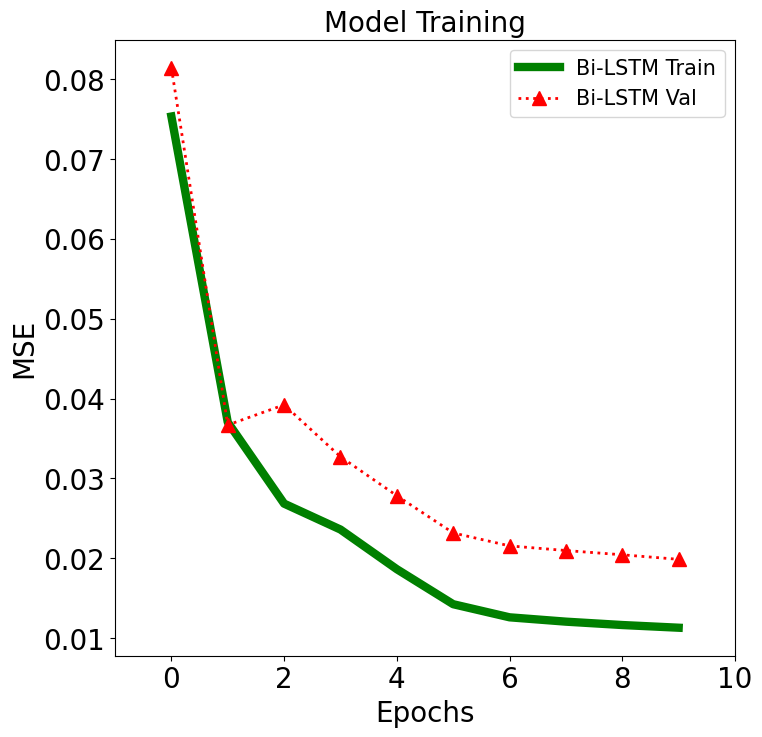

In [22]:
# A method to display the training history
plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams.update({'font.size': 20})

# Currently available choices in the history json file (depends on how the model was trained): "loss", "val_loss", "mae", "val_mae", "mape", "val_mape" 
# In this case, only loss (MSE = mean squared error) is shown.
plt.plot(history_dict_Bi_LSTM['loss'], lw = 6, color = 'green', label = 'Bi-LSTM Train')
plt.plot(history_dict_Bi_LSTM['val_loss'], lw = 2, marker = '^', markevery=1, ms = 10, linestyle ='dotted', color = 'red', label = 'Bi-LSTM Val')

plt.xlim(-1,10)
plt.title('Model Training', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.xlabel('Epochs', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper right', fontsize = 15)
#plt.show()
plt.savefig('Min_max_monthly_training_history.png', dpi=300, bbox_inches = 'tight') # saves directly to where the scrip is located. The save path can be modified.

In [23]:
# A method to load all the preiously saved results

save_results_path = All_Results_folder_path

# possible_selections for "error_type" = ['train_error', 'val_error', 'test_error']
# possible_selections for "error" = ['mse','rmse','mae','mape','nmse','nrmse','nmape','nmae','wmape']
# possible_selections for "phase" = ['Monthly Oil', 'Monthly Gas', 'Monthly Water']
# other possible selections = depends on the available keys (please run the next cell and check the other possibilities)


file = open(os.path.join(save_results_path,'Standard_best_Bi_LSTM_min_max_monthly.pickle'),'rb')
Standard_best_Bi_LSTM_results = pickle.load(file)
file.close()

error_type = 'val_error'
error = 'mse' # all the error types given in the 
phase = 'Monthly Oil'

# Test it
Standard_best_Bi_LSTM_results[error_type].loc[Standard_best_Bi_LSTM_results[error_type]['phase'] == phase][error].mean()

795352.39704978

In [24]:
# Showing all the possible keys
Standard_best_Bi_LSTM_results.keys()

dict_keys(['train_results', 'val_results', 'test_results', 'single_well_results', 'single_well_error', 'train_error', 'val_error', 'test_error'])

In [25]:
# Showing the saved "train_results" contents 
Standard_best_Bi_LSTM_results['train_results']

,Sheet_names,Entity ID,API/UWI List,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Days,Daily Avg Oil,Daily Avg Gas,...,Monthly Gas_CUMSUM,Monthly Gas_predictions,Monthly Gas_norm_predictions,Monthly Gas_CUMSUM_predictions,Monthly Gas_norm_CUMSUM_predictions,Monthly Water_CUMSUM,Monthly Water_predictions,Monthly Water_norm_predictions,Monthly Water_CUMSUM_predictions,Monthly Water_norm_CUMSUM_predictions
6,Bakken,1,1,2016-03-01,6946.0,9821.0,4858.0,30.0,248.07,350.75,...,9821.0,9054.386719,0.469796,9054.386719,0.469796,4858.0,7584.196289,0.361755,7584.196289,0.361755
7,Bakken,1,1,2016-04-01,5310.0,8722.0,4055.0,30.0,177.00,290.73,...,18543.0,7485.807129,0.388409,16540.193359,0.858205,8913.0,5708.488281,0.272287,13292.684570,0.634042
8,Bakken,1,1,2016-05-01,6101.0,9829.0,3994.0,30.0,203.37,327.63,...,28372.0,7190.521484,0.373088,23730.714844,1.231293,12907.0,5464.177734,0.260633,18756.863281,0.894675
9,Bakken,1,1,2016-06-01,5858.0,8809.0,3946.0,31.0,195.27,293.63,...,37181.0,7089.114746,0.367826,30819.830078,1.599119,16853.0,5333.176270,0.254385,24090.039062,1.149060
10,Bakken,1,1,2016-07-01,5634.0,10355.0,3751.0,20.0,181.74,334.03,...,47536.0,6339.170898,0.328915,37159.000000,1.928034,20604.0,4493.445312,0.214331,28583.484375,1.363391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Bakken,5,5,2018-12-01,1348.0,4680.0,950.0,31.0,43.48,150.97,...,200987.0,3923.460938,0.144208,218995.656250,8.049240,48961.0,1450.385986,0.094457,82166.992188,5.351156
412,Bakken,5,5,2019-01-01,1165.0,4133.0,745.0,28.0,37.58,133.32,...,205120.0,4008.237793,0.147324,223003.890625,8.196564,49706.0,1477.768799,0.096240,83644.757812,5.447396
413,Bakken,5,5,2019-02-01,977.0,3103.0,588.0,31.0,34.89,110.82,...,208223.0,4113.935059,0.151209,227117.828125,8.347773,50294.0,1526.955933,0.099444,85171.710938,5.546840
414,Bakken,5,5,2019-03-01,1045.0,2739.0,740.0,30.0,33.71,88.35,...,210962.0,3973.249756,0.146038,231091.078125,8.493811,51034.0,1478.411621,0.096282,86650.125000,5.643122


In [26]:
# Saving a model

# Prepare to save to the "All_Results" folder
folder_name = "Models"
Models_folder_path = os.path.join(script_dir, folder_name)

# Create the "All_Results" folder if it does not already exist
os.makedirs(Models_folder_path, exist_ok=True)

print(f"Folder created at: {Models_folder_path}")

save_path = r'C:\Users\mrkoc\Desktop\RNN_Results\Models'
Standard_best_Bi_LSTM.save(os.path.join(save_path,'Standard_best_Bi_LSTM_monthly.h5'))

Folder created at: C:\Users\mrkoc\Desktop\RNN Production Forecasting\Contextual_Bi_LSTM\Revision\Scripts\Training_and_Saving\Models


In [27]:
# Loading a model
Loaded_Bi_LSTM = tf.keras.models.load_model(os.path.join(save_path,'Standard_best_Bi_LSTM_monthly.h5'))

In [28]:
# Evaluate the loaded model with the available data
Loaded_Bi_LSTM.evaluate(w2_train)
Loaded_Bi_LSTM.evaluate(w2_val)
Loaded_Bi_LSTM.evaluate(w2_test)

45/45 [==============================] - 0s 5ms/step - loss: 0.0092 - mae: 0.0615 - mape: 2671.3530


[0.009222174063324928, 0.06151709705591202, 2671.35302734375]

# Additional Examples
- Additional Examples: (Many-to-One) + LSTM, GRU, Bi-GRU, ANN, Linear Regression

In [29]:
# Standard RNN (many-to-one) 
# To see the explanation on how to train these models using the create_model function, check the training for Bi_GRU at the very bottom of this notebook.

# w2_train_one = w2_one.train
# w2_val_one = w2_one.val
# w2_test_one = w2_one.test

# If desired, you can modify the functions in the "utils" notebook to create a one-to-one or one-to-many model although for production forecasting, it was observed that many-to-many performs brtter (examine how the examples above were created for more insights)

In [30]:
# If desired to create a linear model, you can change the model_type = 'LR'. This still runs an ANN but, a single layer with a linear activation function (Not recommended for production forecasting).

# standard_ann = create_model(final_layer_return_seq = True, loss = 'mse', metrics = ['mae','mape'], layers = 2, dropout_final_layer = False, dropout_value = 0.07490910432625673, units = [144,256], Bi_directional = False, recurrent_dropout = 'zeros', model_type = 'Dense', i = i, optimizer = optimizer)
# standard_ann.summary()

In [31]:
# history_standard_ann = standard_ann.fit(w2_train, epochs=10, validation_data=w2_val, verbose=2, callbacks=[early_stopping])

In [32]:
# standard_LSTM = create_model(final_layer_return_seq = True, loss = 'mse', metrics = ['mae','mape'], layers = 2, dropout_final_layer = False, dropout_value = 0.07490910432625673, units = [144,256], Bi_directional = False, recurrent_dropout = 'zeros', model_type = 'LSTM', i = i, optimizer = optimizer) 
# standard_LSTM.summary()

In [33]:
# history_standard_LSTM = standard_LSTM.fit(w2_train, epochs=10, validation_data=w2_val, verbose=2, callbacks=[early_stopping])

In [34]:
# standard_GRU = create_model(final_layer_return_seq = True, loss = 'mse', metrics = ['mae','mape'], layers = 2, dropout_final_layer = False, dropout_value = 0.07490910432625673, units = [144,256], Bi_directional = False, recurrent_dropout = 'zeros', model_type = 'GRU', i = i, optimizer = optimizer) 
# standard_GRU.summary()

In [35]:
# history_standard_GRU = standard_GRU.fit(w2_train, epochs=10, validation_data=w2_val, verbose=2, callbacks=[early_stopping])

In [36]:
# For Bi-directional models -> units = [forward units, backward units] (repeat for each layer)
    # units format = when layers = 2 --> units = [[244,250],[132,245]]
    # In the example below, since layers = 2, there are 2 units moving forward and backward --> units = [[244,250],[132,245]]. 
    # So for layer#1 --> units --> [244,250] --> [forward units, backward units] and the next one ([132,245]) is the same for layer#2
# This example is for many-to-many models (check above on how to create many-to-one models using the window generator)
# For many-to-one models, the final_layer_return_seq = False

# standard_Bi_GRU = create_model(final_layer_return_seq = True, loss = 'mse', metrics = ['mae','mape'], layers = 2, dropout_final_layer = False, dropout_value = 0.07490910432625673, units = [[244,250],[132,245]], Bi_directional = True, recurrent_dropout = 'zeros', model_type = 'GRU', i = i, optimizer = optimizer)
# standard_Bi_GRU.summary()

In [37]:
# history_standard_Bi_GRU = standard_Bi_GRU.fit(w2_train, epochs=10, validation_data=w2_val, verbose=2, callbacks=[early_stopping])

# OPTUNA TRIALS

In [ ]:
# For examples of Bayesian Optimization (automatic optimization of model hyperparamters) with Optuna, please check the script named "RNN_Optuna_Optimization_Experiment.py.ipynb" 